# Deep Learning Project | Potato Disease Classification | XCeption

In [1]:
# TensorFlow and Keras for model building
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Other utilities
import os
import numpy as np
import matplotlib.pyplot as plt


Constants

In [2]:
IMAGE_SIZE = 299
BATCH_SIZE = 32
CLASSES = 4
EPOCHS = 20

Dataset directory declaration

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C://Users//REYES//OneDrive//Desktop//CNN_Projects//DATASETS//AMPALAYA_DS", #Folder name or directory
shuffle=True,
image_size=(IMAGE_SIZE, IMAGE_SIZE),
batch_size=BATCH_SIZE
)

#Calls and Displays class names from dataset
class_names = dataset.class_names
class_names 

Found 2300 files belonging to 4 classes.


['Healthy',
 'Nitrogen Deficient',
 'Phosphorus Deficient',
 'Potassium Deficient']

# Splitting Dataset to 80-10-10, training, validation and test respectively

In [4]:
# Function for augmenting images using preprocessing layers
def augment(image):
    image = keras.layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE)(image)  # Randomly crop image
    image = keras.layers.RandomRotation(0.4)(image)  # Randomly rotate image
    image = keras.layers.RandomContrast(0.1)(image)  # Randomly adjust contrast
    image = keras.layers.RandomFlip("horizontal_and_vertical")(image)  # Randomly flip image
    image = keras.layers.RandomBrightness([0.1, 0.2])(image)  # Randomly adjust brightness

    return image

# Load and augment the training set
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000, augment_data=True):
    
    # Get length of dataset
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)  # Shuffle dataset before splitting
    
    # Compute percentage accordingly from dataset size
    train_size = int(train_split * ds_size) 
    val_size = int(val_split * ds_size) 
    
    # Split the dataset into training, validation, and test sets
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    if augment_data:
        # Apply augmentation only to the training set
        augmented_train_ds = train_ds.map(lambda x, y: (augment(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        
        # Concatenate the original training data with the augmented data
        train_ds = train_ds.concatenate(augmented_train_ds)
    
    return train_ds, val_ds, test_ds

# Assuming you already loaded your dataset into `dataset`
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [5]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Load XCeption Model

In [6]:
# Load the pre-trained Xception model, without the top classification layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Add custom layers on top of Xception for leaf classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer to reduce dimensions

# Add a fully connected dense layer
x = Dense(1024, activation='relu')(x)

In [7]:
# Add the final output layer for classification (number of classes)
predictions = Dense(4, activation='softmax')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
# Freeze all layers in the base Xception model
for layer in base_model.layers:
    layer.trainable = False

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [9]:
# Compile the model with an Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# #create a callback function to stop training when the validation loss does not improve
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


In [11]:
# Train the model on the dataset
history = model.fit(
    train_ds,
    epochs=EPOCHS,  # You can increase the number of epochs based on your dataset
    validation_data=val_ds,
    callbacks=[stop_early, lr_scheduler]
)


Epoch 1/20
114/114 [==============================] - 140s 474ms/step - loss: 11.8039 - accuracy: 0.4978 - val_loss: 2.0804 - val_accuracy: 0.6429 - lr: 0.0010
Epoch 2/20
114/114 [==============================] - 25s 223ms/step - loss: 2.6474 - accuracy: 0.6014 - val_loss: 0.6249 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 3/20
114/114 [==============================] - 26s 224ms/step - loss: 1.5113 - accuracy: 0.6779 - val_loss: 0.5842 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 4/20
114/114 [==============================] - 26s 226ms/step - loss: 1.5784 - accuracy: 0.6724 - val_loss: 0.5619 - val_accuracy: 0.7946 - lr: 0.0010
Epoch 5/20
114/114 [==============================] - 26s 226ms/step - loss: 1.0014 - accuracy: 0.7344 - val_loss: 0.3454 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 6/20
114/114 [==============================] - 26s 227ms/step - loss: 0.8594 - accuracy: 0.7558 - val_loss: 0.2824 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 7/20
114/114 [==============================

# Model Evualuation

In [12]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 29s 212ms/step - loss: 0.2771 - accuracy: 0.9023


In [25]:
# code to view f1 score and other metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

8/8 [==============================] - 2s 244ms/step
F1 Score: 0.21422684975017414
Precision: 0.21010741045321635
Recall: 0.2578125
Accuracy: 0.2578125
              precision    recall  f1-score   support

           0       0.26      0.52      0.34        62
           1       0.31      0.15      0.21        71
           2       0.00      0.00      0.00        56
           3       0.24      0.34      0.28        67

    accuracy                           0.26       256
   macro avg       0.20      0.25      0.21       256
weighted avg       0.21      0.26      0.21       256



d:\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\tf_gpu\lib\site-packag

In [28]:
# Unfreeze only a subset of layers
for layer in base_model.layers[:80]:  # Freeze the first 100 layers
    layer.trainable = False
for layer in base_model.layers[80:]:  # Unfreeze the rest
    layer.trainable = True

# Recompile the model for fine-tuning (with a lower learning rate)
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# resnet_model.compile(optimizer=RMSprop(learning_rate=0.0001), 
#                loss='sparse_categorical_crossentropy', 
#                metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [30]:
history_finetune = model.fit(
    train_ds,
    epochs=5,  # Additional epochs for fine-tuning
    batch_size = 16,
    validation_data=val_ds,
    callbacks=[stop_early, lr_scheduler]
)

Epoch 1/5
114/114 [==============================] - 53s 416ms/step - loss: 0.7522 - accuracy: 0.6859 - val_loss: 34.8576 - val_accuracy: 0.3170 - lr: 0.0010
Epoch 2/5
114/114 [==============================] - 47s 409ms/step - loss: 0.2885 - accuracy: 0.8868 - val_loss: 0.8600 - val_accuracy: 0.8304 - lr: 0.0010
Epoch 3/5
114/114 [==============================] - 46s 405ms/step - loss: 0.2012 - accuracy: 0.9227 - val_loss: 0.3896 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 4/5
114/114 [==============================] - 46s 404ms/step - loss: 0.1253 - accuracy: 0.9529 - val_loss: 0.8153 - val_accuracy: 0.8214 - lr: 0.0010
Epoch 5/5
114/114 [==============================] - 47s 408ms/step - loss: 0.0976 - accuracy: 0.9627 - val_loss: 0.0741 - val_accuracy: 0.9777 - lr: 0.0010


In [33]:
# code to view f1 score and other metrics
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

8/8 [==============================] - 2s 214ms/step
F1 Score: 0.42132977012550543
Precision: 0.42099855567226885
Recall: 0.421875
Accuracy: 0.421875
              precision    recall  f1-score   support

           0       0.34      0.34      0.34        62
           1       0.38      0.37      0.37        71
           2       0.52      0.52      0.52        56
           3       0.46      0.48      0.47        67

    accuracy                           0.42       256
   macro avg       0.42      0.43      0.42       256
weighted avg       0.42      0.42      0.42       256



In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

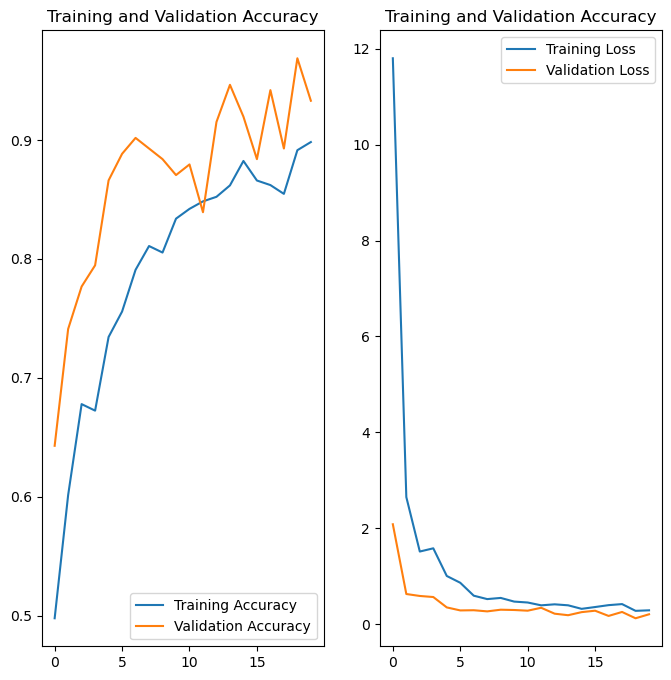

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()

# Making a Prediction

Image to predict
Actual label:  Fresh leaf
1/1 [==============================] - 0s 50ms/step
Prediction:  Fresh leaf


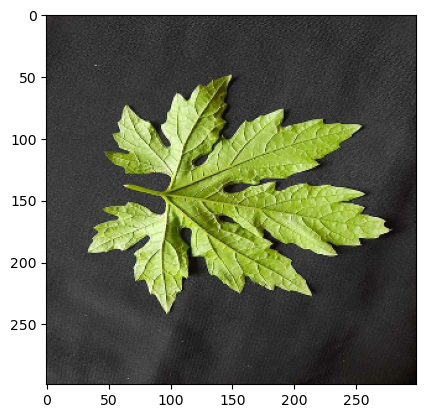

In [45]:
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print("Image to predict")
    plt.imshow(first_image)
    print("Actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Prediction: ", class_names[np.argmax(batch_prediction[0])])


Function for model prediction

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


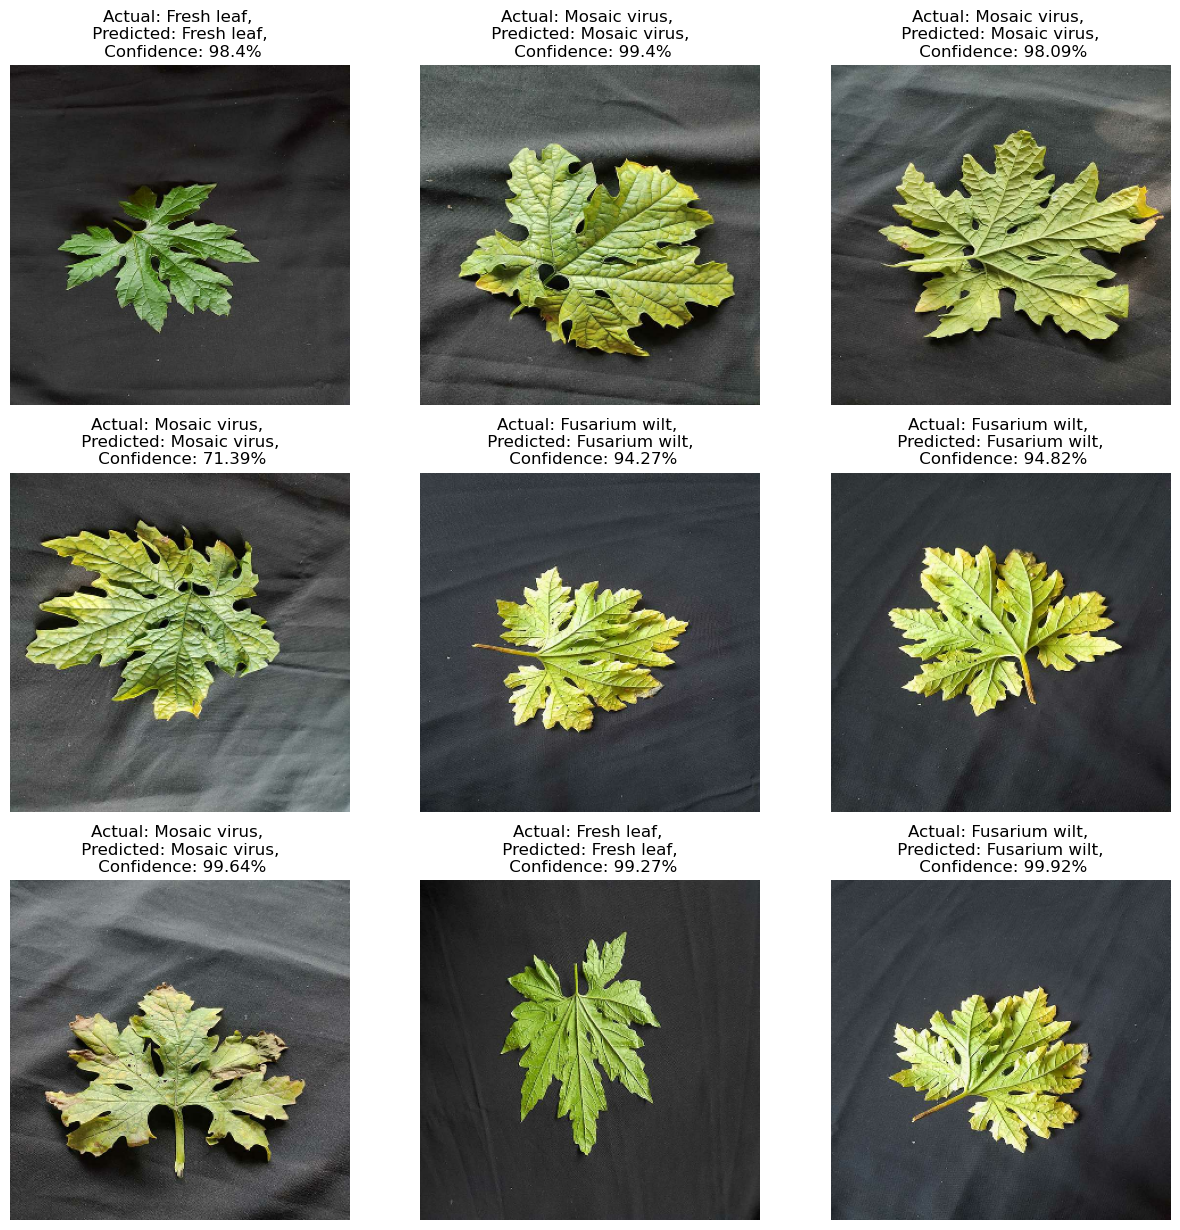

In [47]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving Model

In [49]:
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
